# Top-K Multi-Dimensional Motif and Matches Discovery

This tutorial builds on the [Multidimensional Motif Discovery](https://stumpy.readthedocs.io/en/latest/Tutorial_Multidimensional_Motif_Discovery.html) tutorial as it generalizes the search for a single multidimensional motif to multiple multidimensional motifs and their nearest neighbors (i.e. matches). We will show how the function `mmotifs`, which extends this advanced motif and match search, works by setting and explaining the different input parameters. The `mmotifs` function is the multidimensional analogue of the one-dimensional [motifs](https://github.com/TDAmeritrade/stumpy/blob/main/stumpy/motifs.py) function that can be found in the STUMPY API.

Note that the following function is only visualizing all the motifs and matches that we will find.

In [3]:
def show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls):
    num_motifs = motifs_distances.shape[0]

    for motif_num in range(num_motifs):
        motif_indices = motifs_indices[motif_num]
        mdl = motifs_mdls[motif_num]
        S = motifs_subspaces[motif_num]
        subspace = [df.columns.values[s] for s in S]

        k = len(S)
        f, axs = plt.subplots(k, 1, figsize=(20, 10), sharex=True)
        plt.suptitle(f"The {k}-dimensional motif")

        for j, s in enumerate(S):
            time_series = df[df.columns[s]]
            if k > 1:
                ax = axs[j]
            else:
                ax = axs
            ax.plot(time_series, c="0.75")
            ax.set_title(df.columns.values[s])

            motif_idx = motif_indices[0]
            nn_idx = motif_indices[1]
            ax.plot(time_series[motif_idx : motif_idx + m], c="r", linewidth=4)
            ax.plot(time_series[nn_idx : nn_idx + m], c="r", linewidth=4)
            # ax.axvline(x=motif_idx, linestyle='dashed', c='k', linewidth=2)
            # ax.axvline(x=nn_idx, linestyle='dashed', c='k', linewidth=2)

            # Only relevant if you want to find further matches
            # Set motif_indices[2:] to avoid double counting the motif pair
            [ax.plot(time_series[match : match + m], linewidth=3) for match in motif_indices[2:]]


## Getting started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import stumpy
from stumpy import core
from stumpy.mmotifs import mmotifs

plt.style.use(
    "https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle"
)

## Loading, Preprocessing and Visualizing the Dataset

In the following we will take a look at the [Electrical Load Measurement](https://pureportal.strath.ac.uk/en/datasets/refit-electrical-load-measurements-cleaned) dataset, that consists of electrical load measurements for different appliances from households in the UK. To reduce the amount of data somewhat, we consider only the period from april 19 to may 15 of the year 2014. Also we want to take a closer look at only the five appliances `Fridge-Freezer`, `Freezer`, `Tumble Dryer`, `Diswasher` and `Washing Machine` and see if we are able to find meaningful motifs and matches on this multidimensional time series data! We simplify our life a bit more by converting the timestamps, which are sampled to 8 second intervals, to minutes in order to reduce the overall data size:

In [5]:
start_date, end_date = "2014-04-19", "2014-05-15"
df = pd.read_csv("../CLEAN_House3.csv")
df["Time"] = pd.to_datetime(df["Time"])
colnames = {
    "Appliance1": "Toaster",
    "Appliance2": "Fridge-Freezer",
    "Appliance3": "Freezer",
    "Appliance4": "Tumble Dryer",
    "Appliance5": "Dishwasher",
    "Appliance6": "Washing Machine",
    "Appliance7": "Television",
    "Appliance8": "Microwave",
    "Appliance9": "Kettle",
}
df = (
    df.rename(colnames, axis="columns")
    .loc[
        :,
        [
            "Time",
            "Fridge-Freezer",
            "Freezer",
            "Tumble Dryer",
            "Dishwasher",
            "Washing Machine",
        ],
    ]
    .query("Time >= @start_date and Time <= @end_date")
    .groupby(pd.Grouper(key="Time", freq="T"))
    .sum()
)

df.head()

,Fridge-Freezer,Freezer,Tumble Dryer,Dishwasher,Washing Machine
Time,,,,,
2014-04-19 00:00:00,0,0,0,0,0
2014-04-19 00:01:00,0,0,0,0,0
2014-04-19 00:02:00,0,0,0,0,0
2014-04-19 00:03:00,0,0,0,0,0
2014-04-19 00:04:00,0,0,0,0,0


Now our dataset contains the time series of the five appliances with timestamps now sampled in minutes. Let's visualize it!

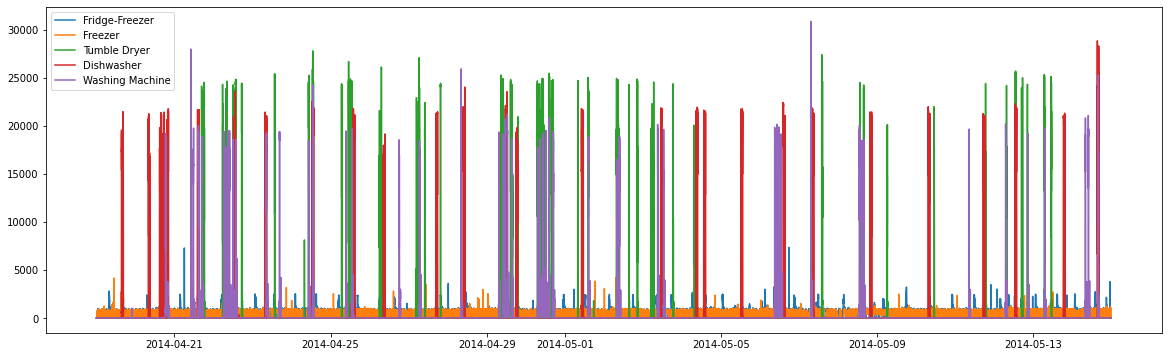

In [6]:
for colname in df.columns:
    plt.plot(df[colname], label=colname)
    plt.legend()

Let us zoom in on a typical afternoon, to get a better feel for this large dataset!

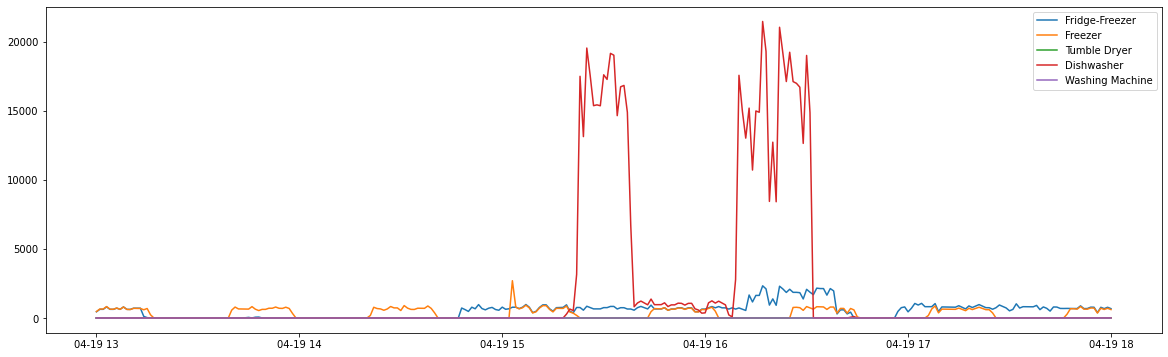

In [7]:
zoom = df.query("Time >= '2014-04-19 13:00:00' and Time <= '2014-04-19 18:00:00'")

for colname in zoom.columns:
    plt.plot(zoom[colname], label=colname)
    plt.legend()

On this day you can clearly see two spikes resulting from the dishwasher usage of one household.
Now let us try to find the most similar patterns across our large dataset.

Unfortunately we first have to eliminate constant regions in order to find meaningful motifs. Otherwise we would only find the areas where no appliances are used and therefore the electrical power demand is constantly 0. This would be a very strong but meaningless motif. To avoid this problem we simply add very low amplitude noise to the constant regions.

After that we will try to find repeated structures spanning four hours within the extracted month.

In [8]:
# m was set to 4 hours
m = 4 * 60

np.random.seed(0)
padded_stddev = np.zeros(len(df))
for colname in df.columns:
    stddev = core.rolling_nanstd(df.loc[:, colname].values, m)
    padded_stddev[-len(stddev):] = stddev
    modified_values = df.loc[:, colname].where(padded_stddev != 0.0, np.nan)
    df = df.assign(**{colname: modified_values})
    # Apply noise to 0 regions
    noise = np.random.uniform(0.0, 0.1, size=len(df))
    zero_idx = df.loc[:, colname].where(df.loc[:, colname] != 0, noise)
    df = df.assign(**{colname: zero_idx})

Before we are able to find motifs and matches with the `mmotifs` function, we first have to compute the mutli-dimensional matrix profile.

But notice: Each row of the resultung array corresponds to each matrix profile for a given dimension, as shown below.

|Array|
|:-----:|
|_1D Matrix Profile_ $...$ |
|_2D Matrix Profile_ $...$ |
| $\vdots$ |
|_5D Matrix Profile_ $...$ |

Therefore the dimensionality of our last row contains the nearest neighbor information of all 5 appliances. In contrast the 3D matrix profile contains the same information but only for three out of the five appliances. But the matrix profile doesn't tell us which of those dimensions are relevant. This information can only be found within the matrix profile subspace, which is one of the return values of the `mmotifs` function. 

We compute the multi-dimensional matrix profile and its indices just like in the [multidimensional motif discovery tutorial](https://stumpy.readthedocs.io/en/latest/Tutorial_Multidimensional_Motif_Discovery.html) as follows:

In [9]:
mps, indices = stumpy.mstump(df.astype(float), m)

## Discovering one motif and its matches

Once we have computed the multi-dimensional matrix profile, we are able to search for repeated structures in multivariate time series. So let us find out how `mmotifs` works by passing specific parameters to this function and discover different motifs and matches along the way. For this we should first understand the outputs that we get from the function:

`motifs_distances`: This array holds the distances corresponding to a set of subsequence matches for each motif. The first column always corresponds to the distance of the self-match for each motif. 
`motifs_indices`: This array holds the indices corresponding to a set of subsequence matches for each motif. Just as with the distances, the first column of the indices is for the self-match for each motif.
`motifs_subspaces`: This list contains the `k`-dimensional subspace for each motif which tells us in which time series dimensions the motifs are located.<br>
`motifs_mdls`: This list contains the MDL-results for finding the dimension of each motif. Given this list, we are able to understand why the motifs are found in exactly that many dimensions when doing an unconstrained search.

This outputs consist of as many rows as motifs are found. The `motifs_distances` and `motifs_indices` contain the multi-dimensional motif pair for each found motif and all other columns contain the most similar subsequences to the motif, ordered by size.

So let us do an completely unconstrained search at first and call `mmotifs` with default parameters! In this case you only have to pass the already computed multi-dimensional distance profile togehter with its indices to the function. Of course, the multidimensional time series or sequence in which the motifs are to be found must not be missing either! Accordingly, the simplest function call is as follows:

In [10]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = mmotifs(
    df.astype(float), mps, indices
)

And of course, we can visualize the results we found with the already defined `show_motifs_matches` function.

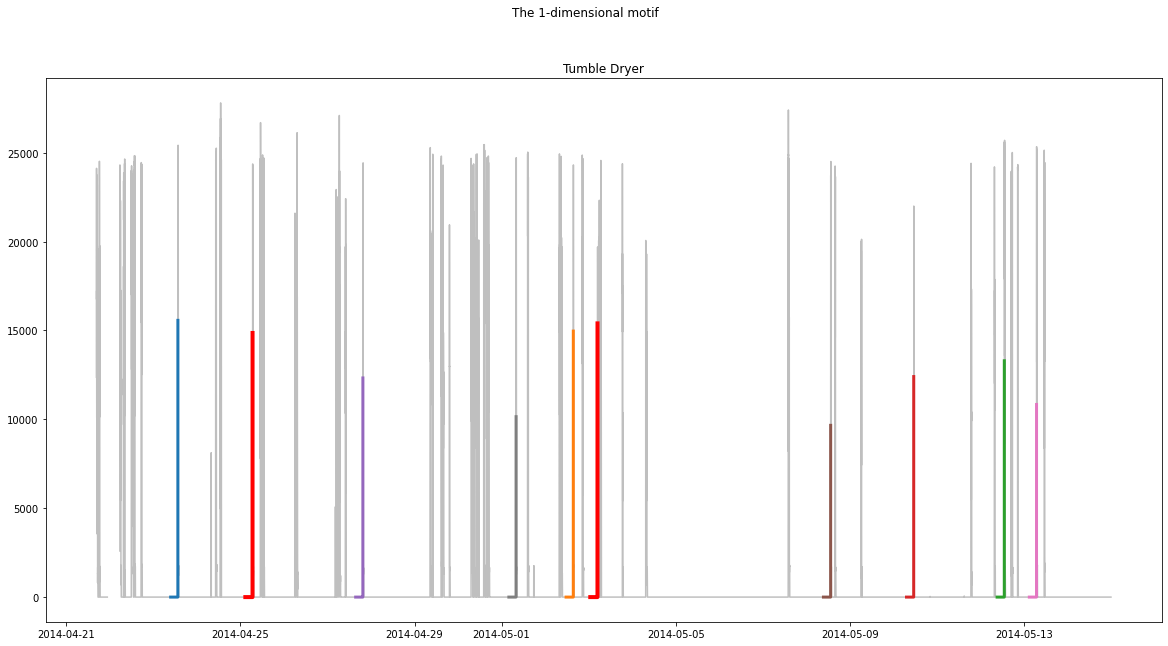

In [11]:
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

Congratulations, you have found your first motif on the `Tumble Dryer` time series! We were able to find all 10 default matches with the motif pair (i. e. the two most similar subsequences) shown in red! 

But this doesn't always have to be the case since the `max_distance` input parameter is computed automatically depending on the distance profile if not explicitly set otherwise. Therefore in this case the `max_distance` parameter was bigger than all of the distances from the motif to its nine nearest neighbors and that's the reason why we were able to find all ten `max_matches`. The `max_matches` input parameter (which is set to 10 by default) is the maximum amount of similar matches (i.e. nearest neighbors) of a representative motif to be returned. But again, notice that the first match is always the self-match for each motif!

Let's plot our discovered matches on top of each other to see how similar they are!

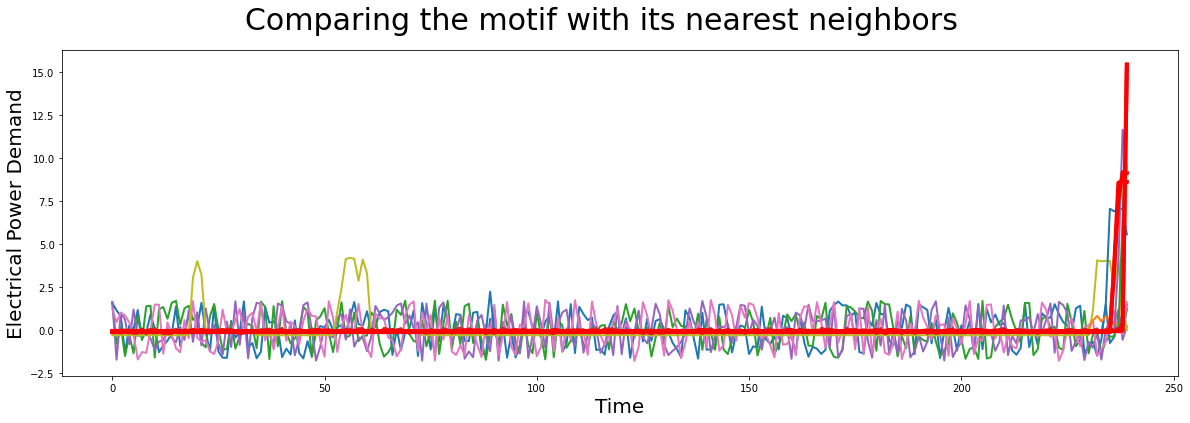

In [49]:
num_motifs = motifs_distances.shape[0]

for motif_num in range(num_motifs):
    motif_indices = motifs_indices[motif_num]
    S = motifs_subspaces[motif_num]
    subspace = [df.columns.values[s] for s in S]
    
    plt.suptitle('Comparing the motif with its nearest neighbors', fontsize='30')
    plt.xlabel('Time', fontsize ='20')
    plt.ylabel('Electrical Power Demand', fontsize='20')    
    for i, match_index in reversed(list(enumerate(motif_indices))):
        match_z_norm = stumpy.core.z_norm(df[subspace].values[match_index: match_index + m])
        if i < 2:
            # Motif pair
            plt.plot(match_z_norm, lw=4, color='red')
        else:
            # Other neighbors
            plt.plot(match_z_norm, lw=2)
    plt.show()


What if we only want to get the motif pair without any further matches? That's easy! Simply specifiy that you want to find two matches by setting `max_matches=2` and plot everything again:

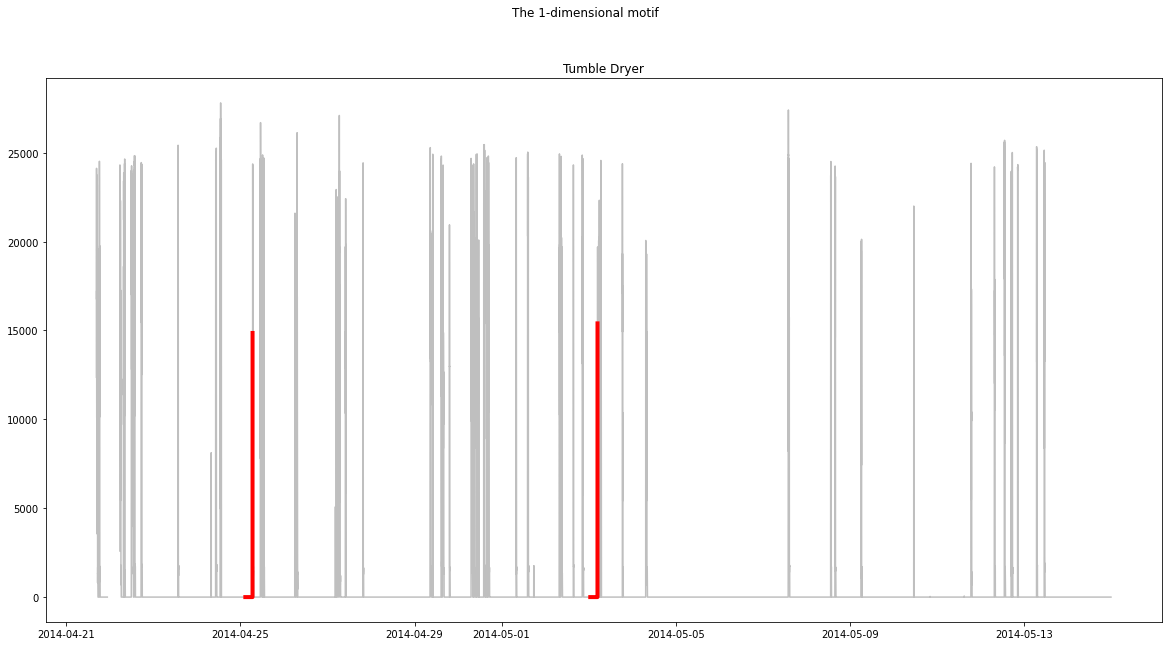

In [12]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = mmotifs(
    df.astype(float), mps, indices, max_matches=2
)
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

Analogously, if you want to find the motif pair with its three nearest neighbors you will need to set `max_matches=5`!
Tip: If you also set the maximal distance that is allowed between a motif and all other subsequences in the time series to _infinity_ (i. e. numpy.inf), you can make sure that you always get _exactly_ 5 matches (even though this is not necessary here sice we were already able to find 10 matches)! So let's see how this works:

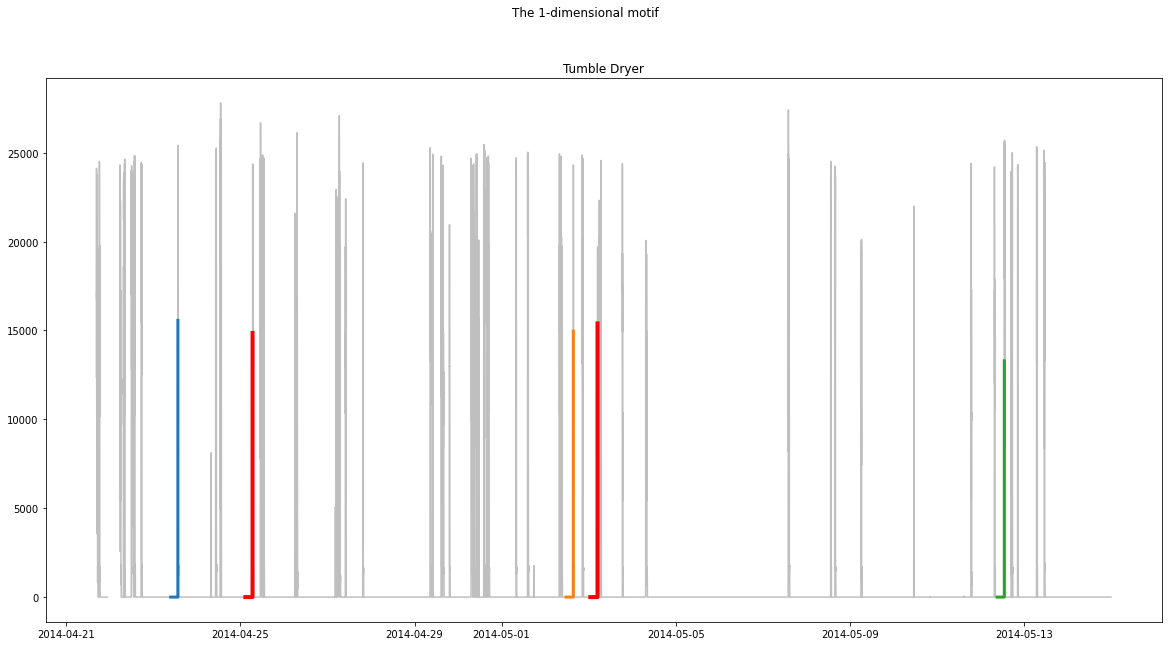

In [13]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = mmotifs(
    df.astype(float), mps, indices, max_distance=np.inf, max_matches=5
)
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

But why did we find the motif and its neighbors only in one dimension - the `Tuble Dryer` dimension? Since we were doing an `unconstrained search` (we didn't tell the `mmotifs` function in how many dimensions to search for the motif and what dimensions to search in) the `mmotifs` function is using the `Minmum Description Length (MDL)` approach (as explained in [multidimensional motif discovery tutorial](https://stumpy.readthedocs.io/en/latest/Tutorial_Multidimensional_Motif_Discovery.html)) in order to find the number `k` of dimensions in which the motif is present. To understand why the motif was found in only one dimension we will take a look at the corresponding MDL plot:

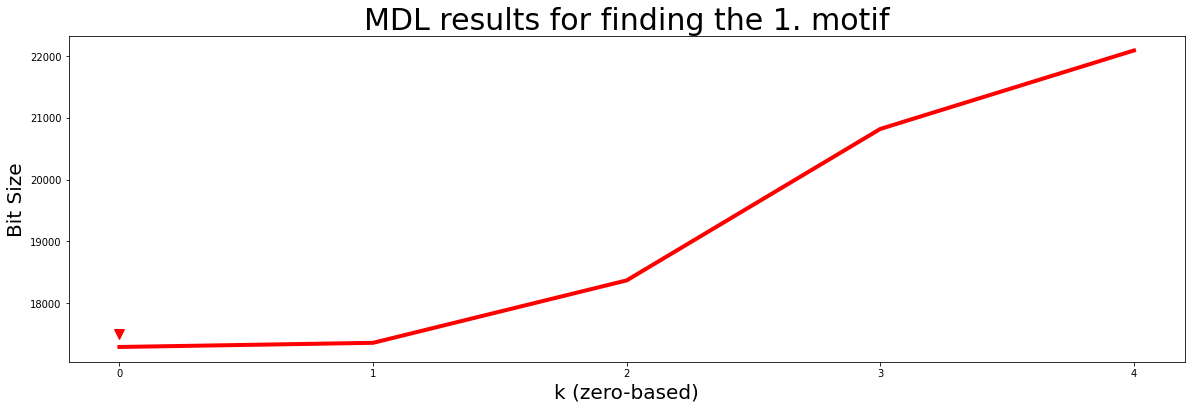

In [17]:
num_motifs = motifs_distances.shape[0]

for motif_num in range(num_motifs):
    mdl = motifs_mdls[motif_num]

    # Plot MDL results
    plt.figure()
    plt.plot(np.arange(len(mdl)), mdl, c='red', linewidth="4")
    plt.title(f"MDL results for finding the {motif_num + 1}. motif", fontsize="30")
    plt.xlabel("k (zero-based)", fontsize="20")
    plt.ylabel("Bit Size", fontsize="20")
    plt.xticks(range(mps.shape[0]))
    plt.plot(0, 17500, marker="v", markersize=10, color='red')

As we can see the `mmotifs` function selected the optimal number of dimensions automatically for us! Here the data gets compressed the most for `k=0` - i.e. in one dimension. As before we don't want to blindly trust the `mmotifs` results without reality check. So let's see if it is really the `Tumble Dryer` dimension that gives the minimum compression size.

In [19]:
num_motifs = motifs_distances.shape[0]

for motif_num in range(num_motifs):
    S = motifs_subspaces[motif_num]
    subspace = [df.columns.values[s] for s in S]
print(subspace)

['Tumble Dryer']


And it really seems to be the `Tumble Dryer` dimenison in which our one-dimensional motif is present! Thus the `mmotifs` function seems to do a good job! So from now on we will trust the judgement of `mmotifs` so we don't have to check the MDL plot and the found subspace manually every time.

## Discovering motifs in multiple dimensions by specifying the number of relevant dimensions

If we don't want to only find a one-dimensional motif since we are interested in finding truely multidimensional motifs, we have to specify in how many dimensions the `mmotifs` function should look for the most similar subsequences. For this purpose the input parameter `k` of the `mmotifs` function is used. The parameter gives the function the number of dimensions (`k+1`, since zero-based) required for discovering the motifs with the desired dimensionality. So let's try to find a motif in two dimensions:

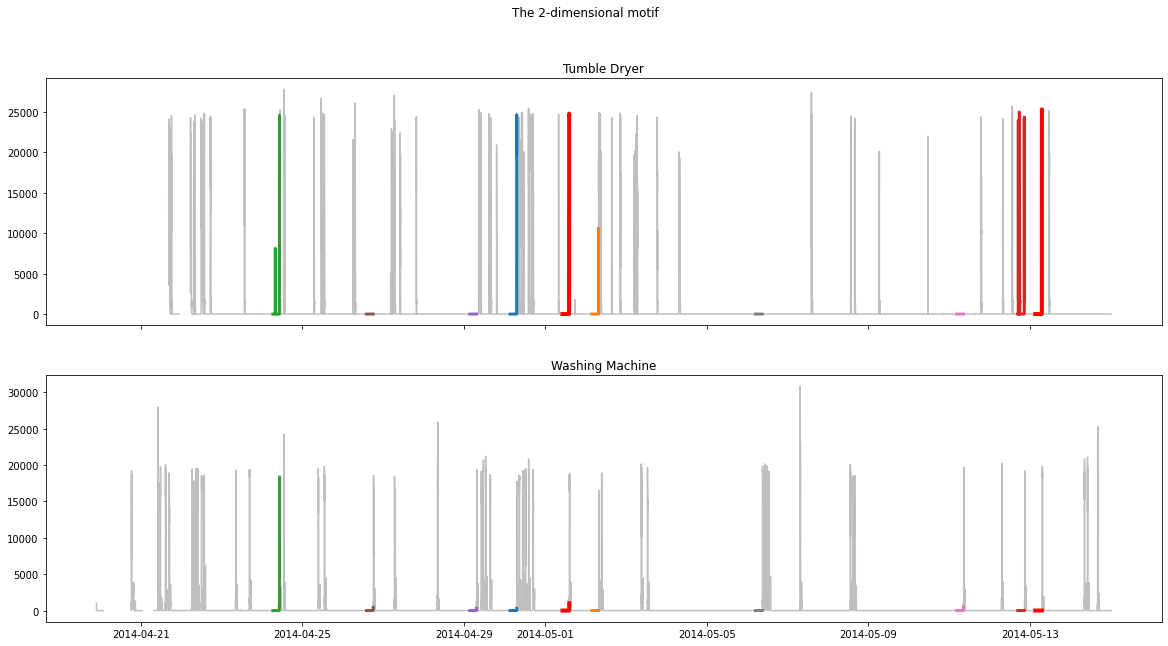

In [20]:
motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls = mmotifs(
    df.astype(float), mps, indices, k=1
)
show_motifs_matches(df, motifs_distances, motifs_indices, motifs_subspaces, motifs_mdls)

Congratulations! You have found your first two-dimensional motif with its nearest neighbors! The relevant dimensions are the electrical load measurements of the `Tumble Dryer` and the `Washing Machine`. Since both appliances are usually used in succession within a short time period, the found two-dimensional motif makes sense.

## Finding multiple multi-dimensional motifs